Defining the autoencoder module

In [53]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from tensorflow.keras import backend as K

# r'/Users/elliotlindestam/Documents/Skola/Indek icloud/trioptima' 
your_path = r'C:\Users\gusta\Documents\KTH\TriOptima\trioptima'

# Load preprocessed data
file_path = your_path + '/CLEAN_Processed.csv'  # Please replace 'your_path' with actual path
data_preprocessed = pd.read_csv(file_path, header=0)

# Check to make sure the data is in expected format
assert data_preprocessed.applymap(np.isreal).all().all(), "Non-numeric data found"
assert not data_preprocessed.isnull().any().any(), "NaN values found"

# Dimensions
input_dim = data_preprocessed.shape[1]
encoding_dim = int(input_dim / 2)

# Set layer and neurons options
layer_options = [1, 5]
neuron_options = [1, 100, 500]

# Variables to store the best model's configurations and weights
best_val_loss = float('inf')  # Set initial value to infinity
best_num_layers = None
best_num_neurons = None
best_weights = None

# Iterate over neuron configurations
for num_neurons in neuron_options:
    # Iterate over layer configurations
    for num_layers in layer_options:
        K.clear_session()

        input_layer = layers.Input(shape=(input_dim,))
        encoder_layer = layers.Dense(num_neurons, activation='relu')(input_layer)
        
        # Add extra layers based on num_layers
        for _ in range(1, num_layers):
            encoder_layer = layers.Dense(num_neurons, activation='relu')(encoder_layer)

        decoder_layer = layers.Dense(input_dim, activation='sigmoid')(encoder_layer)

        temp_autoencoder = models.Model(inputs=input_layer, outputs=decoder_layer)
        temp_autoencoder.compile(optimizer='adam', loss='mean_squared_error')
        
        history = temp_autoencoder.fit(
            data_preprocessed, data_preprocessed,
            epochs=10,  # Adjust this as needed
            batch_size=32,
            shuffle=True,
            validation_split=0.1
        )
        
        final_val_loss = history.history['val_loss'][-1]
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_num_layers = num_layers
            best_num_neurons = num_neurons
            best_weights = temp_autoencoder.get_weights()

# Construct the best model with configurations
K.clear_session()
input_layer = layers.Input(shape=(input_dim,))
encoder_layer = layers.Dense(best_num_neurons, activation='relu')(input_layer)
for _ in range(1, best_num_layers):
    encoder_layer = layers.Dense(best_num_neurons, activation='relu')(encoder_layer)
decoder_layer = layers.Dense(input_dim, activation='sigmoid')(encoder_layer)

autoencoder = models.Model(inputs=input_layer, outputs=decoder_layer)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Load the best weights into the best model
autoencoder.set_weights(best_weights)

# Display the number of layers and neurons in the best model
print(f"Best Model Configuration:\nNumber of Layers: {best_num_layers}\nNumber of Neurons per Layer: {best_num_neurons}")


C:\Users\gusta\AppData\Local\Temp\ipykernel_2856\1184043672.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  assert data_preprocessed.applymap(np.isreal).all().all(), "Non-numeric data found"


Epoch 1/10
164/164 [==============================] - 1s 3ms/step - loss: 0.1805 - val_loss: 0.0881
Epoch 2/10
164/164 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0534
Epoch 3/10
164/164 [==============================] - 0s 1ms/step - loss: 0.0403 - val_loss: 0.0502
Epoch 4/10
164/164 [==============================] - 0s 1ms/step - loss: 0.0387 - val_loss: 0.0495
Epoch 5/10
164/164 [==============================] - 0s 1ms/step - loss: 0.0382 - val_loss: 0.0491
Epoch 6/10
164/164 [==============================] - 0s 1ms/step - loss: 0.0379 - val_loss: 0.0489
Epoch 7/10
164/164 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0489
Epoch 8/10
164/164 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0488
Epoch 9/10
164/164 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0487
Epoch 10/10
164/164 [==============================] - 0s 1ms/step - loss: 0.0376 - val_loss: 0.0487

Anomaly detection

In [55]:
# Obtain the reconstructed data
predictions = autoencoder.predict(data_preprocessed)

# Measure the reconstruction error
mse = np.mean(np.power(data_preprocessed - predictions, 2), axis=1)

# Convert mse to a DataFrame for easier handling
mse_df = pd.DataFrame({'reconstruction_error': mse})

# Display basic statistics of the error
print(mse_df.describe())


182/182 [==============================] - 0s 2ms/step
       reconstruction_error
count           5804.000000
mean               0.009983
std                0.096113
min                0.000030
25%                0.000984
50%                0.002600
75%                0.003533
max                5.617277


Visualize

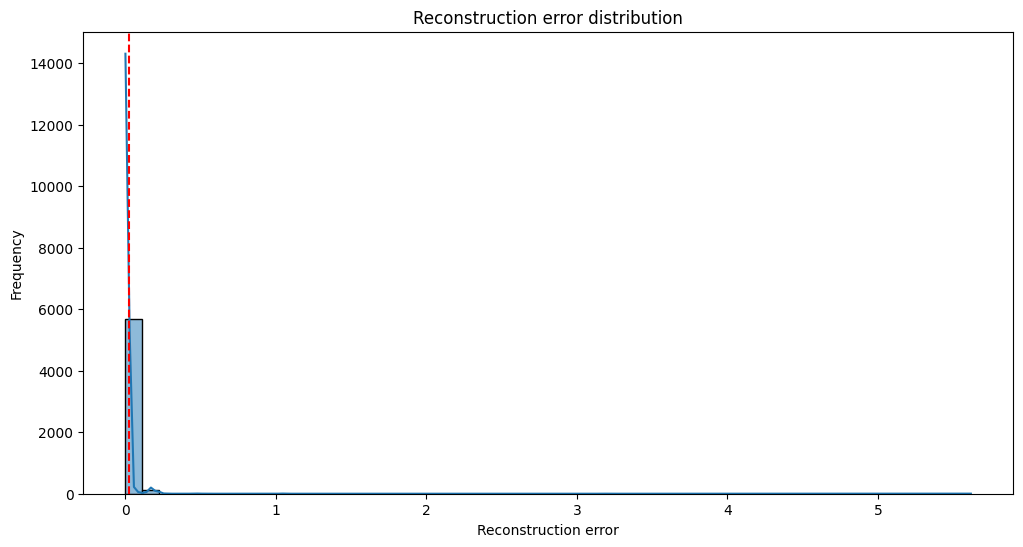

Anomaly threshold: 0.02128724479283591


In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(mse_df['reconstruction_error'], bins=50, kde=True)
plt.title('Reconstruction error distribution')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')


threshold = np.percentile(mse_df['reconstruction_error'], 95)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
plt.show() 
print(f"Anomaly threshold: {threshold}")



Test new data for outliers

In [66]:
import pandas as pd
import numpy as np

# Set the file paths
new_trades_processed_path = your_path + '/Trades_Processed.csv'
new_trades_path = your_path + '/Trades.csv'

# Load new trade data from CSV (both processed and original)
new_trades_processed = pd.read_csv(new_trades_processed_path)
new_trades = pd.read_csv(new_trades_path)

# Make sure the autoencoder variable is already defined and trained
# Predict with the autoencoder
new_predictions = autoencoder.predict(new_trades_processed)

# Measure the reconstruction error
new_mse = np.mean(np.power(new_trades_processed - new_predictions, 2), axis=1)
new_mse_df = pd.DataFrame({'reconstruction_error': new_mse})

# Determine whether each trade is an outlier or not
outlier_indices = new_mse_df[new_mse_df['reconstruction_error'] > threshold].index

# Filter the outlier trades from the original data using the outlier indices
outlier_trades_original = new_trades.iloc[outlier_indices]

# Save the outlier trades to a CSV file in the original format
outlier_file_path = your_path + '/Outlier_Trades_IRS.csv'
outlier_trades_original.to_csv(outlier_file_path, index=False)


1/1 [==============================] - 0s 15ms/step
